# Using QSVT for fixed-point amplitude amplification

This demo will show how to use the QSVT framework for search problems. Specifically, we will implement fixed-point amplitude amplification (FPAA). In FPAA, we do not know in advance the concentration of solutions to the search problem, want to sample a solution with high probability. In contrast, for the original grover search algorithm, too much iterations might 'overshoot'.

The demo is based on the paper [Grand unification of quantum algorithms](#grand).

Given $|s\rangle$ the initial state and $|t\rangle$ the 'good' states, we get an effective block encoding of a 1-dimensional matrix $A=|t\rangle\langle s|$.

Given that  $a = \langle s|t\rangle\gt0$, we want to amplify $a$. The signal operator $U$ here will be $I$ (and also $\dagger{U}$). Now we implement 2 projector-rotations - one in '$|s\rangle$' space and one in '$|t\rangle$' space, each one around the given state, giving phase to the specific state.

## Good states z-rotation - rotation around $|t\rangle$

In [1]:
EQUATION = "(a + b) == 3 and c ^ a == 2"

In [2]:
from classiq import FunctionGenerator, FunctionLibrary, QReg, QUInt, RegisterUserInput
from classiq.builtin_functions import Arithmetic, RZGate

qsvt_library = FunctionLibrary()
fg = FunctionGenerator(function_name="target_state_rotation")

rz_params = RZGate(phi="theta")

arith_params = Arithmetic(
    expression=EQUATION,
    definitions=dict(
        a=RegisterUserInput(size=2),
        b=RegisterUserInput(size=1),
        c=RegisterUserInput(size=3),
    ),
    uncomputation_method="optimized",
    inputs_to_save=["a", "b", "c"],
    target=RegisterUserInput(size=1, name="res"),  # this gives the input it's name
)

input_reg = fg.create_inputs({"TARGET": QUInt[6], "aux": QUInt[1]})

out_arith = fg.Arithmetic(
    arith_params,
    in_wires={
        "a": input_reg["TARGET"][:2],
        "b": input_reg["TARGET"][2:3],
        "c": input_reg["TARGET"][3:],
        "arithmetic_target": input_reg["aux"],
    },
)
out_z = fg.RZGate(rz_params, in_wires={"TARGET": out_arith["expression_result"]})

out_arith = fg.Arithmetic(
    arith_params,
    is_inverse=True,
    release_by_inverse=True,
    in_wires={
        "a": out_arith["a"],
        "b": out_arith["b"],
        "c": out_arith["c"],
        "expression_result": out_z["TARGET"],
    },
)

reg_out = QReg.concat(QReg.concat(out_arith["a"], out_arith["b"]), out_arith["c"])
fg.set_outputs({"TARGET": reg_out, "aux": out_arith["arithmetic_target"]})
qsvt_library.add_function(fg.to_function_definition())

## Initial state z-rotation - rotation around $|s\rangle$

In [3]:
from classiq import ControlState, QReg
from classiq.builtin_functions import (
    PhaseGate,
    UniformDistributionStatePreparation,
    XGate,
)

fg = FunctionGenerator(function_name="initial_state_rotation")
NUM_QUBITS = 6

sp_params = UniformDistributionStatePreparation(num_qubits=NUM_QUBITS)

rz_params = RZGate(phi="theta")


input_dict = fg.create_inputs({"TARGET": QUInt[NUM_QUBITS], "aux": QReg[1]})

out_sp_dag = fg.UniformDistributionStatePreparation(
    sp_params,
    is_inverse=True,
    strict_zero_ios=False,
    in_wires={"OUT": input_dict["TARGET"]},
)


control_state = ControlState(ctrl_state="0" * (NUM_QUBITS), name="CTRL")
out_mcx = fg.XGate(
    XGate(),
    control_states=control_state,
    in_wires={"TARGET": input_dict["aux"], "CTRL": out_sp_dag["IN"]},
)

out_x = fg.RZGate(
    params=rz_params,
    in_wires={"TARGET": out_mcx["TARGET"]},
)

out_mcx2 = fg.XGate(
    XGate(),
    control_states=control_state,
    in_wires={"TARGET": out_x["TARGET"], "CTRL": out_mcx["CTRL"]},
)

out_sp = fg.UniformDistributionStatePreparation(
    sp_params, strict_zero_ios=False, in_wires={"IN": out_mcx2["CTRL"]}
)
fg.set_outputs({"TARGET": out_sp["OUT"], "aux": out_mcx2["TARGET"]})
qsvt_library.add_function(fg.to_function_definition())

## Create the full QSVT Model

In [4]:
from classiq import Constraints, Model
from classiq.builtin_functions import HGate, Identity

DEGREE = 25
X_BASIS = True

model = Model()
model.include_library(qsvt_library)

# state preparation
signal_reg = model.UniformDistributionStatePreparation(sp_params)["OUT"]
if X_BASIS:
    aux_reg = model.HGate(HGate())["TARGET"]
    wires_dict = {"TARGET": signal_reg, "aux": aux_reg}
else:
    wires_dict = {"TARGET": signal_reg}

# We need odd polynomial since we must end at the end state. This is why we need the sign function
# and not just y(x) = 1, which is even.
for i in range((DEGREE + 1) // 2):
    wires_dict = model.target_state_rotation(
        parameters_dict={"theta": f"p{2*i}"}, in_wires=wires_dict
    )
    wires_dict = model.initial_state_rotation(
        parameters_dict={"theta": f"p{2*i+1}"}, in_wires=wires_dict
    )

if (DEGREE + 1) % 2 == 1:
    wires_dict = model.target_state_rotation(
        parameters_dict={"theta": f"p{DEGREE}"}, in_wires=wires_dict
    )

if X_BASIS:
    h_out = model.HGate(HGate(), in_wires={"TARGET": wires_dict["aux"]})["TARGET"]
else:
    h_out = wires_dict["aux"]
model.set_outputs(
    {
        "a": wires_dict["TARGET"][:2],
        "b": wires_dict["TARGET"][2:3],
        "c": wires_dict["TARGET"][3:],
        "aux": h_out,
    }
)

### get the phase sequence for the sign function

Now we will use the package `pyqsp` in order to get the phases of the rotation sequence.
Get directly the coef of the sign function, based on the erfc approximation.

In [5]:
import pyqsp

pg = pyqsp.poly.PolySign()
pcoefs, scale = pg.generate(
    degree=DEGREE, delta=10, ensure_bounded=True, return_scale=True
)

[pyqsp.poly.PolySign] degree=25, delta=10
[PolyTaylorSeries] max [0.89999955] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.09627814175488839 in the domain [-1, 1] using degree 25


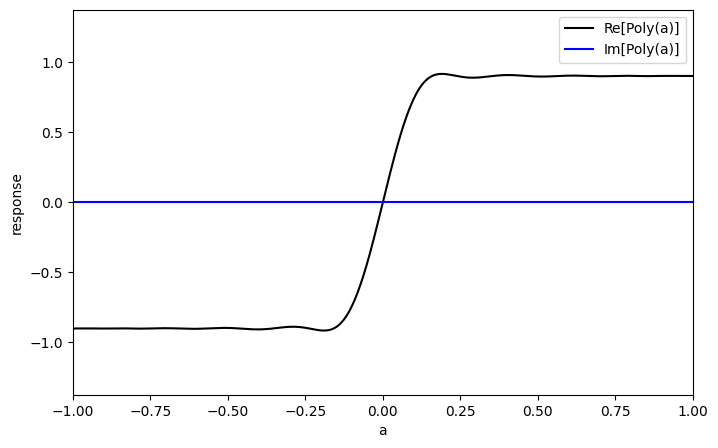

In [6]:
import numpy as np
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

poly = Polynomial(pcoefs)
# choosing 'z' this basis since P(1)=1 and won't to avoid the QSP basis change. Anyway, we are not measuring directly this qubit.
measurement = "x"
if not X_BASIS:
    measurement = "z"
ang_seq = QuantumSignalProcessingPhases(
    poly, signal_operator="Wx", method="laurent", measurement=measurement
)
pyqsp.response.PlotQSPResponse(ang_seq, signal_operator="Wx", measurement=measurement)

As $R(a)=-i*e^{i\frac{\pi}{4}Z}W(a)e^{i\frac{\pi}{4}Z}$ and we have odd number of rotations, we get an $i$ phase to our polynomial, so we get $Im(P(a))$ instead of the real part. So we will get the result in the $|1\rangle$ state in the ancilla. However, we can fix it by adding $\pi/2$ phase to the last or first rotation.

In [7]:
#### change the R(x) to W(x), as the phases are in the W(x) conventions
phases = np.array(ang_seq)
phases = phases - np.pi / 2
phases[0] = phases[0] + np.pi / 4
phases[-1] = phases[-1] + np.pi / 4 + np.pi / 2

phases = (
    -2 * phases
)  # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp

## Synthesis and execution on a simulator

We will use classiq's synthesis engine to translate the model to a quantum circuit, and execute on the `aer simulator`

In [8]:
import numpy as np

from classiq import execute, show, synthesize
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

NUM_SHOTS = 1000
model.execution_preferences = ExecutionPreferences(
    num_shots=NUM_SHOTS,
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator"),
)

parameters = {f"p{i}": float(phases[i]) for i in range(len(phases))}
model.sample(execution_params=parameters)

model.constraints = Constraints(max_width=12)
qmod = model.get_model()

In [9]:
with open("qsvt_fixed_point_amplitude_amplification.qmod", "w") as f:
    f.write(qmod)

In [10]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/a09b9325-4078-49ea-bbd3-5c5cdb44b61a?version=0.34.0.dev0%2B124706fb0e


Execute the circuit:

In [11]:
from classiq.execution import ExecutionDetails

raw_results = execute(qprog).result()
results = raw_results[0].value

In [12]:
def to_int(x):
    return int(x, 2)


def equation(a, b, c):
    return eval(EQUATION)


for key, counts in results.counts_of_multiple_outputs(["a", "b", "c", "aux"]).items():
    a, b, c, aux = to_int(key[0]), to_int(key[1]), to_int(key[2]), to_int(key[3])
    if equation(a, b, c):
        print(
            f"a: {a}, b: {b}, c: {c}, aux: {aux}, equation_result: {equation(a, b, c)}, counts={counts}"
        )

a: 3, b: 0, c: 1, aux: 0, equation_result: True, counts=8
a: 2, b: 1, c: 0, aux: 0, equation_result: True, counts=9


What do we expect?

We need to subtitue the amplitude of $|s\rangle\langle t|$ in $P(x)$:

In [13]:
NUM_SHOTS * (poly(np.sqrt(2 / 2**6)) ** 2)

832.9888756684967

Indeed, we got the expected result according to the polynomial we created with the QSVT sequence.

## References

<a id='grand'>[1]</a>: [Martyn JM, Rossi ZM, Tan AK, Chuang IL. Grand unification of quantum algorithms. PRX Quantum. 2021 Dec 3;2(4):040203.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203)
